# Clustering Consulting Project 

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

In [1]:
import findspark

In [2]:
findspark.init('/home/coffey/spark-2.2.0-bin-hadoop2.7')

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('hacker').getOrCreate()

In [31]:
df = spark.read.csv('hack_data.csv', inferSchema=True, header=True)

In [7]:
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [14]:
df.groupBy('Location').count().describe().show()  

+-------+-----------+------------------+
|summary|   Location|             count|
+-------+-----------+------------------+
|  count|        181|               181|
|   mean|       null|1.8453038674033149|
| stddev|       null|1.0156238047166788|
|    min|Afghanistan|                 1|
|    max|   Zimbabwe|                 6|
+-------+-----------+------------------+



#==> we know there is 181 different Locations, and generally, each location only show 2 twice. 
# I don't know whether I'd better use this features or not, but just for practice, I want to OneHotEncodeing the 'Location' features anyway.

In [29]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [16]:
lc_indexer = StringIndexer(inputCol='Location', outputCol='lcIndex')
lc_encoder = OneHotEncoder(inputCol='lcIndex', outputCol='lcVec')

In [32]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [20]:
assembler = VectorAssembler(inputCols=['Session_Connection_Time','Bytes Transferred','Kali_Trace_Used','Servers_Corrupted','Pages_Corrupted','WPM_Typing_Speed', 'lcVec']
                            , outputCol='features')

In [30]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [23]:
kmean = KMeans(featuresCol='scaledFeatures',k=3)

In [33]:
pipline = Pipeline(stages=[lc_indexer, lc_encoder, assembler, scaler, kmean])

In [34]:
fit_model = pipline.fit(df)

In [35]:
results = fit_model.transform(df)

In [37]:
results.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37, lcIndex=54.0, lcVec=SparseVector(180, {54: 1.0}), features=SparseVector(186, {0: 8.0, 1: 391.09, 2: 1.0, 3: 2.96, 4: 7.0, 5: 72.37, 60: 1.0}), scaledFeatures=SparseVector(186, {0: 0.5679, 1: 1.3658, 2: 1.9976, 3: 1.2859, 4: 2.2849, 5: 5.3963, 60: 12.9423}), prediction=0)]

# like above process, I used Pipeline, but I can't get the cost function..... Let me approach another way.

1.OneHotEncode 'Location'

In [50]:
lc_indexer2 = StringIndexer(inputCol='Location', outputCol='lcIndex')
lc_encoder2 = OneHotEncoder(inputCol='lcIndex', outputCol='lcVec')

In [47]:
df2 = lc_indexer2.fit(df).transform(df)

In [51]:
df3 = lc_encoder2.transform(df2)

In [53]:
df3.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37, lcIndex=54.0, lcVec=SparseVector(180, {54: 1.0}))]

2. assembler features.

In [55]:
assembler2 = VectorAssembler(inputCols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed','lcVec'], outputCol='features')

In [56]:
df_assem = assembler2.transform(df3)

In [57]:
df_assem.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37, lcIndex=54.0, lcVec=SparseVector(180, {54: 1.0}), features=SparseVector(186, {0: 8.0, 1: 391.09, 2: 1.0, 3: 2.96, 4: 7.0, 5: 72.37, 60: 1.0}))]

3.scale 'features'

In [58]:
scaler2 = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [61]:
df_scaled = scaler2.fit(df_assem).transform(df_assem)

In [63]:
df_scaled.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37, lcIndex=54.0, lcVec=SparseVector(180, {54: 1.0}), features=SparseVector(186, {0: 8.0, 1: 391.09, 2: 1.0, 3: 2.96, 4: 7.0, 5: 72.37, 60: 1.0}), scaledFeatures=SparseVector(186, {0: 0.5679, 1: 1.3658, 2: 1.9976, 3: 1.2859, 4: 2.2849, 5: 5.3963, 60: 12.9423}))]

4.kmean clustering!

In [64]:
kmeans2 = KMeans(featuresCol='scaledFeatures', k=2)

In [65]:
clusters = kmeans2.fit(df_scaled)

In [68]:
clusters.computeCost(df_scaled)

61590.16105511677

# OK, this approach seems working! I'm going to create a funciton and visualize cost on different k!

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/home/coffey/spark-2.2.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


In [71]:
k_list = [2, 3, 4, 5, 6,7]

In [73]:
def get_k_wssse(k_list, final_data):
    k_wssse = {}
    for k in k_list:
        kmeans = KMeans(featuresCol='scaledFeatures', k=k)
        model = kmeans.fit(final_data)
        wssse = model.computeCost(final_data)
        k_wssse[k] = wssse  
    return k_wssse

In [75]:
def to_dataframe(dic):
    
    wssse = pd.DataFrame(dic, index=['wssse'])
    wssse = wssse.transpose()
    wssse = wssse.reset_index()
    
    return wssse

In [76]:
k_wssse = get_k_wssse(k_list, df_scaled)

In [77]:
wssse = to_dataframe(k_wssse)

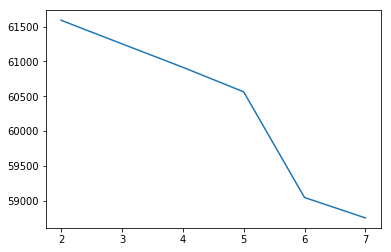

In [78]:
plt.plot(wssse['index'], wssse['wssse'])

# it looks interesting! Let's explore a little bit more! Let's set k_list=list(range(1, 20))

In [82]:
k_list1 = list(range(2, 20))

In [83]:
k_wssse1 = get_k_wssse(k_list1, df_scaled)

In [84]:
wssse1 = to_dataframe(k_wssse1)

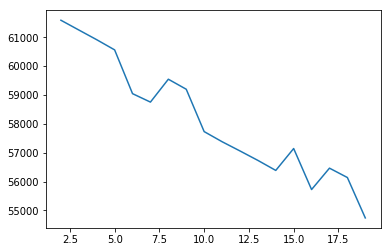

In [86]:
plt.plot(wssse1['index'], wssse1['wssse'])

#it does't show the elbow graph! I guess it is because I have conclude the 'Location' in features. So the bigger k I chose, the better cost is. 

# Now, let's get rid of 'Location' and do cluster again!

In [87]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [88]:
data = df.select(['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'])

In [89]:
assember3 = VectorAssembler(inputCols=data.columns, outputCol='features')

In [90]:
data_assem = assember3.transform(data)

In [93]:
scaler3 = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [96]:
data_scaled = scaler3.fit(data_assem).transform(data_assem)

In [100]:
data_scaled.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, WPM_Typing_Speed=72.37, features=DenseVector([8.0, 391.09, 1.0, 2.96, 7.0, 72.37]), scaledFeatures=DenseVector([0.5679, 1.3658, 1.9976, 1.2859, 2.2849, 5.3963]))]

In [101]:
k_wssse3 = get_k_wssse(k_list1, data_scaled)

In [102]:
wssse3 = to_dataframe(k_wssse3)

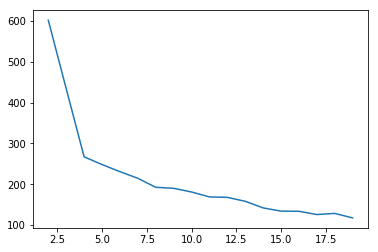

In [103]:
plt.plot(wssse3['index'], wssse3['wssse'])

# This is an awesome results! According to the elbow curve, I could say if I only compared with k=2 and k=3, then the better solution is k=3. So there are three hackers doing the hacking stuff.:D